---
# Evaluate and plot the training results
---

### Package imports

In [1]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import xarray as xr

from dantro.plot.utils import ColorManager
import matplotlib.patches as patches

from _style import colors, rcParams
from _plot_utils import get_iso3, plot_world_network, plot_trade_utility_comp, plot_trade_utility_comp_map

### Plot style settings

In [2]:
# Default figure height and width for easy integration into Latex documents
_PAGEWIDTH = 7.1

# Axes titles settings
axes_title_props = dict(fontweight='bold', ha='left')

# Default ColorManager: green-yellow-red
cm_GrYeOr = ColorManager(
    cmap={'continuous': True, 'from_values': {0: colors['c_lightgreen'], 0.5: colors['c_yellow'], 1: colors['c_orange']}},
    vmin=0,
    vmax=1,
)
cm_GrYeRe = ColorManager(
    cmap={'continuous': True, 'from_values': {0: colors['c_lightgreen'], 0.5: colors['c_yellow'], 1: colors['c_red']}},
    vmin=0,
    vmax=1,
)   

---
# Load the data
---

In [3]:
# Load the lookup table, containing coordinates and ISO codes
lookup_table = pd.read_csv("data/lookup_table.csv", index_col=0)

In [4]:
# Load the FAO data and sample datasets, using a helper function
def load_FAO_data(path):
    _d = xr.load_dataarray(path)
    _d = _d.assign_coords({
        "Source": [get_iso3(lookup_table, c) for c in _d.coords["Source"].data],
        "Destination": [get_iso3(lookup_table, c) for c in _d.coords["Destination"].data]})
    return _d

dsets = {}
for _source in ["Barley", "Beef", "Wine", "Wheat", ("Dairy", "Dairy_all"), ("Sugar", "Sugar_products"), "Corn", "Tomatoes", ("Soya", "Soya_beans"), ("Lettuce", "Vegetables"), ("Cucumbers", "Cucumbers_and_gherkins")]:
    if isinstance(_source, tuple):
        _name, _source = _source
    else:
        _name = _source
    dsets[_name] = dict(
        FAO_data=load_FAO_data(f"data/FAO_Data/{_source}_pooled_0.99_2000-2022.nc").sel({"Element": "Quantity, t"}, drop=True).transpose('Reporter', 'Year', 'Source', 'Destination'),
        Predictions=xr.load_dataset(f"data/NN_samples/{_source}_pooled_0.99_2000-2022_samples_stats.nc"))

# Load the yield dataset
yields = xr.load_dataarray("data/FAO_data/yields.nc")
yields = yields.assign_coords({"Area": [get_iso3(lookup_table, c) for c in yields.coords["Area"].data]})


# Load the world shapefile
world = gpd.read_file("data/world_shapefile/ne_50m_admin_0_countries.shp")
world.to_crs("EPSG:3857", inplace=True)

---
# 1. War in Ukraine
---

### Ukrainian and Russian export maps, 2021--2022

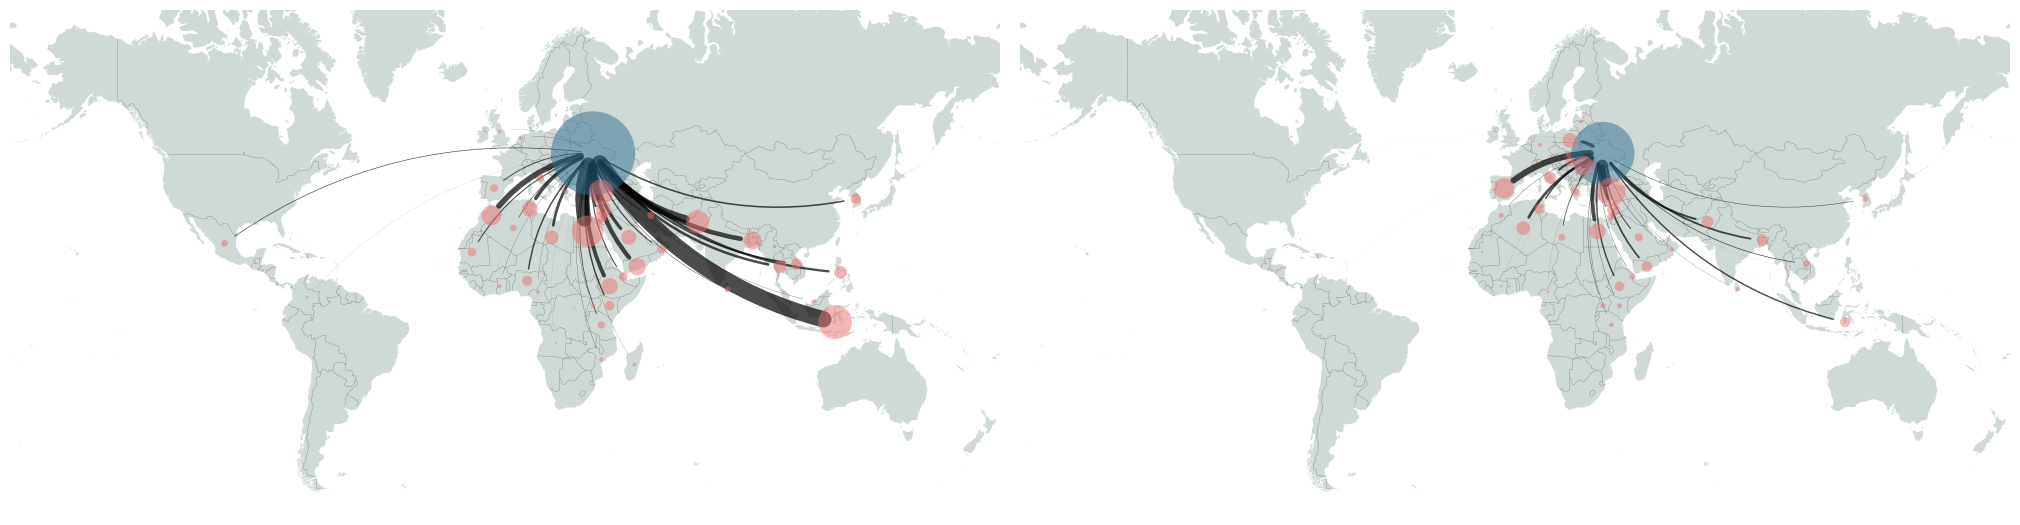

In [5]:
# Plot Ukrainian exports for 2021 and 2022
fig, axs = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Mercator()), ncols=2)

_plot_props = dict(arrow_dict=dict(arrowstyle='-'), size_factor=0.1, width_factor=8e-2, add_sea=False, exporter_color=colors['c_darkblue'], importer_color=colors['c_red'], landcolor=colors['c_lightgrey'], fig=fig)

plot_world_network(dsets["Wheat"]["FAO_data"].sel({"Source": ["UKR"], "Year": 2021}).mean("Reporter", skipna=True), lookup_table, ax=axs[0], **_plot_props)

plot_world_network(dsets["Wheat"]["FAO_data"].sel({"Source": ["UKR"], "Year": 2022}).mean("Reporter", skipna=True), lookup_table, ax=axs[1], **_plot_props)

fig.subplots_adjust(wspace=0.02, hspace=0)

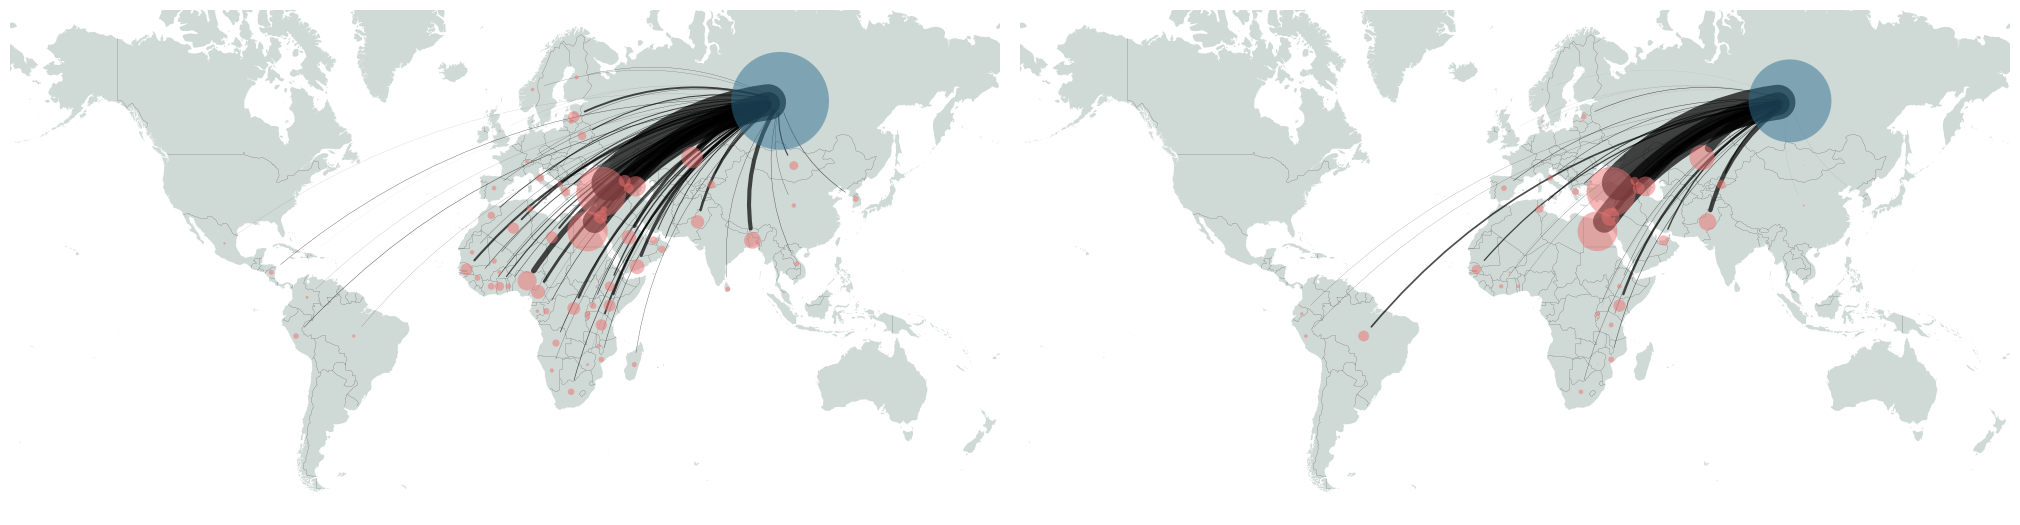

In [6]:
# Plot Russian exports for 2021 and 2022
fig, axs = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Mercator()), ncols=2)

_plot_props = dict(arrow_dict=dict(arrowstyle='-'), size_factor=0.1, width_factor=8e-2, add_sea=False, exporter_color=colors['c_darkblue'], importer_color=colors['c_red'], landcolor=colors['c_lightgrey'], fig=fig)

plot_world_network(dsets["Wheat"]["FAO_data"].sel({"Source": ["RUS"], "Year": 2021}).mean("Reporter", skipna=True), lookup_table, ax=axs[0], **_plot_props)

plot_world_network(dsets["Wheat"]["FAO_data"].sel({"Source": ["RUS"], "Year": 2022}).mean("Reporter", skipna=True), lookup_table, ax=axs[1], **_plot_props)

fig.subplots_adjust(wspace=0.02, hspace=0)

### Changes in trade volume and cost

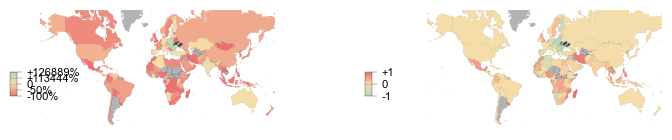

In [7]:
# Ukraine
fig, axs = plot_trade_utility_comp_map(dsets["Wheat"]["Predictions"], year1=2021, year2=2022, source="UKR", world=world, colors=colors, figsize=(_PAGEWIDTH, 1.2))

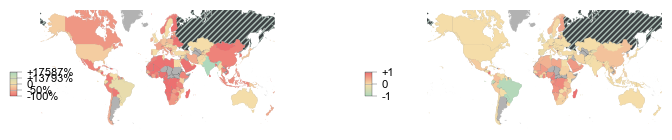

In [8]:
# Russia
fig, axs = plot_trade_utility_comp_map(dsets["Wheat"]["Predictions"], year1=2021, year2=2022, source="RUS", world=world, colors=colors, figsize=(_PAGEWIDTH, 1.2))

### Drop in trade volume and utility, selected countries

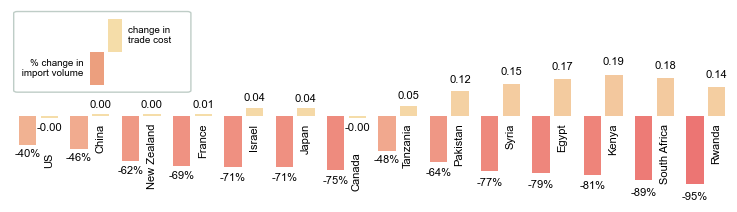

In [26]:
# Plot a comparison for Ukraine
fig, axs = plot_trade_utility_comp(dsets["Wheat"]["Predictions"], lookup_table,
                              source="UKR", 
                              year1=2021, year2=2022,
                              destinations=["USA", "CHN", "NZL", "FRA", "ISR", "JPN", "CAN", "TZA", "PAK", "SYR", "EGY", "KEN", "ZAF", "RWA"],
                              colors=colors, 
                              figsize=(_PAGEWIDTH, 1.2))

# Add a legend
legend_ax = fig.add_axes([0.1, 0.85, 0.05, 0.6])
legend_ax.bar([0, 1], [-10, +10], color=[colors['c_orange'], colors['c_yellow']], lw=0)
legend_ax.text(-0.75, -5, '% change in\n import volume', ha='right', va='center', fontsize=7)
legend_ax.text(1.75, 5, 'change in\ntrade cost', ha='left', va='center', fontsize=7)
legend_ax.axis('off')
box_ax = fig.add_axes([-0.01, 0.8, 0.26, 0.7], zorder=-2)
box_ax.xaxis.set_visible(False)
box_ax.yaxis.set_visible(False)
for s in ['top', 'bottom', 'right', 'left']:
    box_ax.spines[s].set_visible(False)
rect = patches.FancyBboxPatch((0.02, 0.02), 0.96, 0.96, linewidth=1, edgecolor=colors['c_lightgrey'], alpha=0.8, facecolor='white', transform=box_ax.transAxes, boxstyle='Round, pad=0, rounding_size=0.02')
box_ax.add_patch(rect)

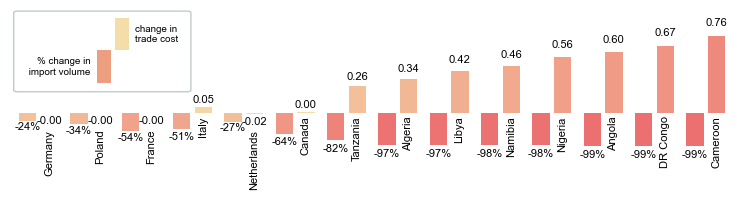

In [10]:
fig, axs = plot_trade_utility_comp(dsets["Wheat"]["Predictions"], lookup_table,
                              source="RUS", 
                              year1=2021, year2=2022,
                              destinations=["DEU", "POL", "FRA", "ITA", "NLD", "CAN", "TZA", "DZA", "LBY", "NAM", "NGA", "AGO",  "COD", "CMR"],
                              colors=colors, 
                              figsize=(_PAGEWIDTH, 1.2))

# Add a legend
legend_ax = fig.add_axes([0.11, 0.54, 0.05, 0.6])
legend_ax.bar([0, 1], [-10, +10], color=[colors['c_orange'], colors['c_yellow']], lw=0)
legend_ax.text(-0.75, -5, '% change in\n import volume', ha='right', va='center', fontsize=7)
legend_ax.text(1.75, 5, 'change in\ntrade cost', ha='left', va='center', fontsize=7)
legend_ax.axis('off')
box_ax = fig.add_axes([-0.01, 0.48, 0.26, 0.7], zorder=-2)
box_ax.xaxis.set_visible(False)
box_ax.yaxis.set_visible(False)
for s in ['top', 'bottom', 'right', 'left']:
    box_ax.spines[s].set_visible(False)
rect = patches.FancyBboxPatch((0.02, 0.02), 0.96, 0.96, linewidth=1, edgecolor=colors['c_lightgrey'], alpha=0.8, facecolor='white', transform=box_ax.transAxes, boxstyle='Round, pad=0, rounding_size=0.02')
box_ax.add_patch(rect)

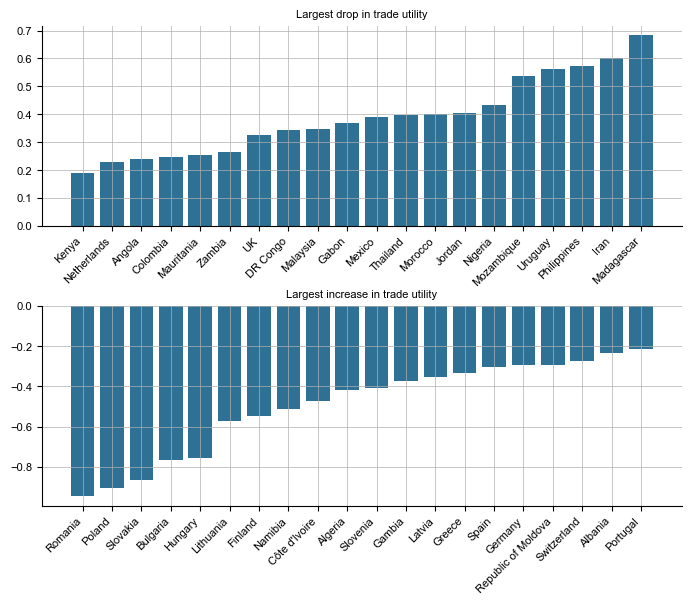

In [11]:
# Largest drops in trade and utility
from _plot_utils import get_diff, property_from_iso3

fig, axs = plt.subplots(nrows=2, gridspec_kw=dict(hspace=0.4))

axs[0].set_title("Largest drop in trade utility")
axs[1].set_title("Largest increase in trade utility")


_wheat_c = dsets["Wheat"]["Predictions"]["mean"].sel({"variable": "C"})
_util_drop_UKR = get_diff(_wheat_c, source="UKR", year1=2021, year2=2022).isel({"Destination": get_diff(_wheat_c, source="UKR", year1=2021, year2=2022).squeeze().argsort().data}).squeeze().dropna("Destination")

axs[0].bar([property_from_iso3(lookup_table, iso, item="Name") for iso in _util_drop_UKR.coords["Destination"].data[-20:]], _util_drop_UKR[-20:])
axs[1].bar([property_from_iso3(lookup_table, iso, item="Name") for iso in _util_drop_UKR.coords["Destination"].data[:20]], _util_drop_UKR[:20])

for idx in [0, 1]:
    axs[idx].set_xticks(axs[idx].get_xticks(), [s._text for s in axs[idx].get_xticklabels()], 
                        rotation=45, ha='right')

---
# 2. Trade in Southeast Asia and Asia-Pacific
---

### Barley

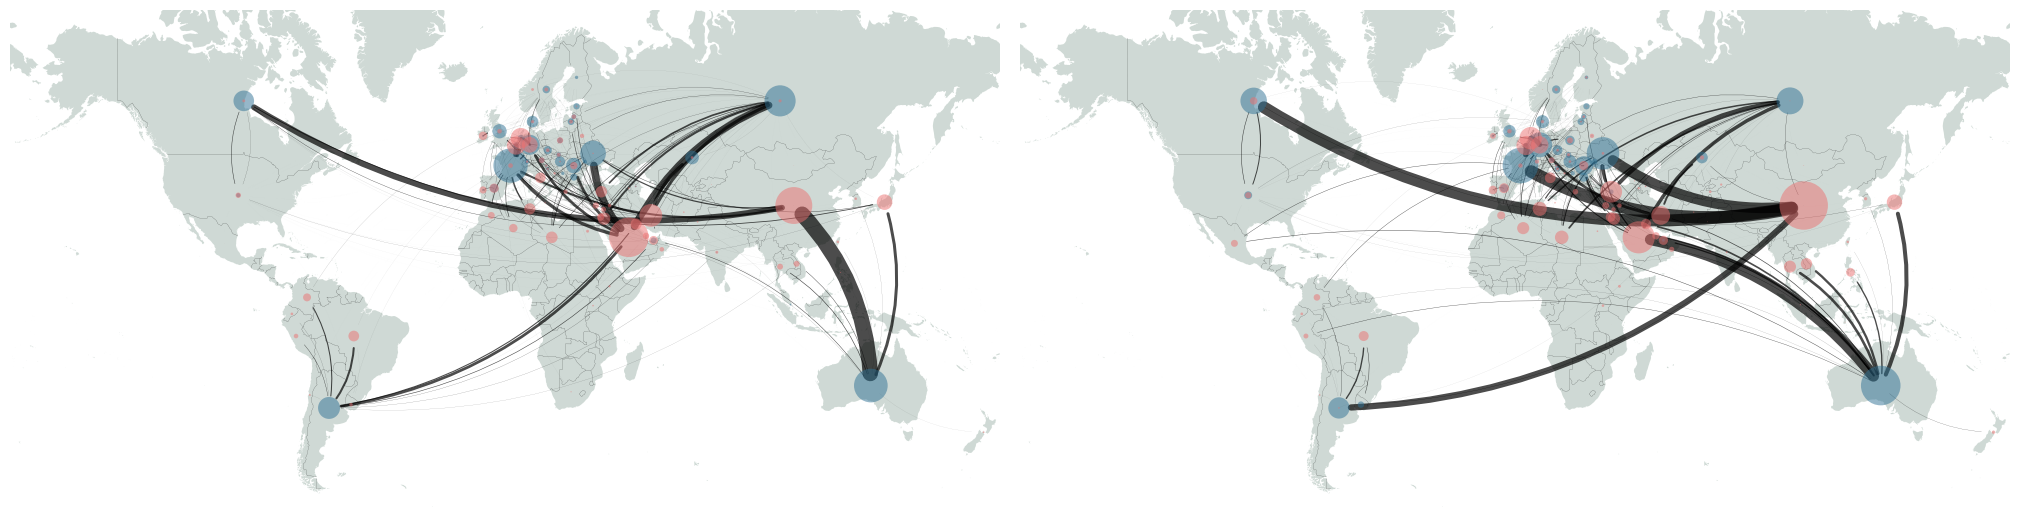

In [12]:
# Compare the global barley trade, 2018 and 2021
fig, axs = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Mercator()), ncols=2)
_plot_props = dict(fig=fig, arrow_dict=dict(arrowstyle='-'), size_factor=0.05, width_factor=5e-2, add_sea=False, landcolor=colors['c_lightgrey'], exporter_color=colors['c_darkblue'], importer_color=colors['c_red'])

plot_world_network(dsets["Barley"]["FAO_data"].sel({"Year": 2018}).mean("Reporter", skipna=True), lookup_table, ax=axs[0], **_plot_props)

plot_world_network(dsets["Barley"]["FAO_data"].sel({"Year": 2021}).mean("Reporter", skipna=True), lookup_table, ax=axs[1], **_plot_props)
fig.subplots_adjust(wspace=0.02, hspace=0)

Missing: Serbia and Montenegro
Missing: Other
Missing: Serbia and Montenegro
Missing: Other


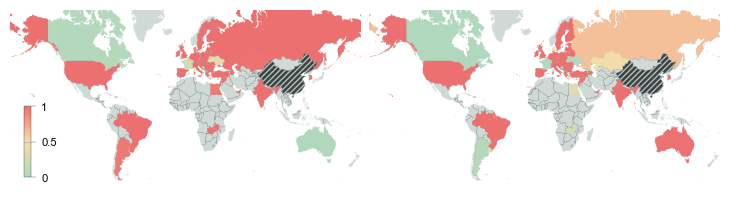

In [13]:
# Plot the change in trade utility with China
from _plot_utils import plot_background_map
fig, axs = plt.subplots(figsize=(7.1, 3.55), subplot_kw=dict(projection=ccrs.Mercator()), ncols=2)

# Only consider Chinese imports
china_imports = dsets["Barley"]["Predictions"]["mean"].sel({"Destination": "CHN"}, drop=True)
china_imports = china_imports.sel({"variable": "C"})

# Plot two years
for year, ax in [(2018, axs[0]), (2021, axs[1])]:
    
    # Plot the background
    plot_background_map(fig, ax, borders_lw = 0.1, add_sea=False, landcolor=colors['c_lightgrey'])

    _dset = china_imports.sel({"Year": year})

    # Highlight trading partners
    for source in _dset.coords["Source"].data:
        if source in list(world['ISO_A3_EH']):
            if source == "CHN":
                world[world['ISO_A3_EH'] == source].plot(color=colors['c_darkgrey'], ax=ax, zorder=0, lw=0.1, edgecolor=colors['c_lightgrey'], hatch=r"//////")
            else:
                _color = cm_GrYeRe.map_to_color(_dset.sel({"Source": source}))
                world[world['ISO_A3_EH'] == source].plot(color=_color, ax=ax, zorder=0, lw=0.1, edgecolor=_color)
        else:
            print(f"Missing: {source}")

# Add a colorbar
import matplotlib.colorbar as colorbar
cax = fig.add_axes([0.02, 0.28, 0.01, 0.2])
cbar = colorbar.Colorbar(cax, cmap=cm_GrYeRe.cmap, orientation='vertical', location='right', drawedges=False)
cbar.set_ticks(ticks=[0, 0.5, 1], labels=[0, 0.5, 1])
cbar.outline.set_linewidth(0.2)
cax.tick_params(width=0.2)
fig.subplots_adjust(wspace=0.02, hspace=0)

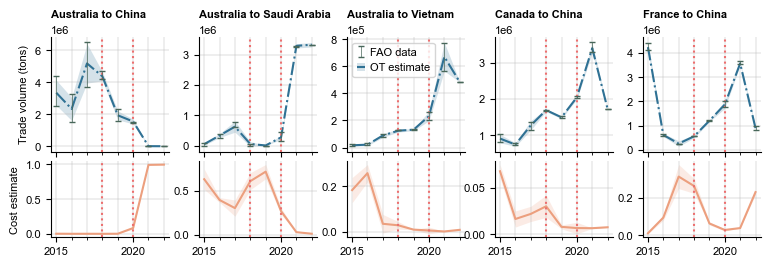

In [14]:
# Compare the barley trade
from matplotlib.ticker import MultipleLocator
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(_PAGEWIDTH, 2), sharex=True, gridspec_kw={'height_ratios': [1.5, 1]})

handles = []
for idx, (ex, im) in enumerate([("AUS", "CHN"), ("AUS", "SAU"), ("AUS", "VNM"), ("CAN", "CHN"), ("FRA", "CHN")]):
    
    ax = axs[0, idx]
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    # True transport flow (quantity)
    _T = dsets["Barley"]["FAO_data"].sel({"Source": ex, "Destination": im}).dropna("Year").sel({"Year": range(2015, 2023)})

    # Plot the true quantity flow
    _d = ax.errorbar(_T.coords["Year"], _T.mean("Reporter"), yerr=_T.std("Reporter"), lw=0, elinewidth=0.5, capsize=2, zorder=5, 
                     color=colors['c_darkgreen'])

    if idx == 0:
        handles.append((_d))

    # Plot the predicted transport flow
    _T_pred = dsets["Barley"]["Predictions"].sel({"variable": "T_pred", "Source": ex, "Destination": im}).sel({"Year": range(2015, 2023)})
    _fb = ax.fill_between(
        _T_pred.coords["Year"], 
        _T_pred["mean"] - _T_pred["std"], 
        _T_pred["mean"] + _T_pred["std"], 
        alpha=0.2, lw=0, color=colors['c_darkblue']
    )
    _l = ax.plot(_T_pred.coords["Year"], _T_pred["mean"], color=colors['c_darkblue'], linestyle='-.')
    if idx == 0:
        handles += [(_fb, _l[0])]
    
    ax.grid(which='both', axis='both', lw=0.3)
    ax.grid(True, which='both')
    ax.set_title(f"{property_from_iso3(lookup_table, ex, item='Name')} to {property_from_iso3(lookup_table, im, item='Name')}", y=1.1, x=0, **axes_title_props)
    ax = axs[1, idx]
    
    # Plot the predicted cost
    _C_pred = dsets["Barley"]["Predictions"].sel({"variable": "C", "Source": ex, "Destination": im, "Year": range(2015, 2023)})
    _fb = ax.fill_between(_C_pred.coords["Year"], 
                    _C_pred["mean"]-_C_pred["std"], 
                    _C_pred["mean"]+_C_pred["std"], alpha=0.2, color=colors['c_orange'], lw=0)
    _l = ax.plot(_C_pred.coords["Year"], _C_pred["mean"], label="Cost", color=colors['c_orange'])
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(which='both', axis='both', lw=0.3)
    ax.grid(True, axis='x', which='both')

# Add legend and labels
axs[0, 2].legend(handles=handles, labels=["FAO data", "OT estimate"], loc='upper left', handlelength=0.7, handletextpad=0.5) 
axs[0, 0].set_ylabel("Trade volume (tons)")
axs[1, 0].set_ylabel("Cost estimate")

for ax in axs.flatten():
    for y in [2018, 2020]:
        ax.axvline(y, linestyle='dotted', lw=1.5, color=colors['c_red'])
fig.subplots_adjust(hspace=0.1, wspace=0.25)

### Australia-China trade

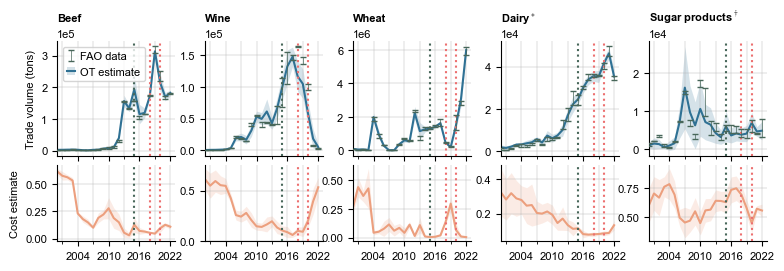

In [15]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(_PAGEWIDTH, 2), sharex=True, gridspec_kw={'height_ratios': [1.5, 1]})

im, ex = "CHN", "AUS"

handles = []
for idx, commodity in enumerate(["Beef", "Wine", "Wheat", "Dairy", "Sugar"]):
    
    ax = axs[0, idx]
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    # Plot the true quantity flow (FAO data)
    _T = dsets[commodity]["FAO_data"].sel({"Source": ex, "Destination": im}).dropna("Year")
    _d = ax.errorbar(_T.coords["Year"], _T.mean("Reporter"), yerr=_T.std("Reporter"), color=colors['c_darkgreen'], lw=0, elinewidth=0.5, capsize=2, label=f"FAO data", zorder=5)

    # Plot the predicted transport flow
    _T_pred = dsets[commodity]["Predictions"].sel({"variable": "T_pred", "Source": ex, "Destination": im})
    _fb = ax.fill_between(
        _T_pred.coords["Year"], 
        _T_pred["mean"] - _T_pred["std"], 
        _T_pred["mean"] + _T_pred["std"], 
        alpha=0.2, lw=0, color=colors['c_darkblue']
    )
    _l = ax.plot(_T_pred.coords["Year"], _T_pred["mean"], color=colors['c_darkblue'], linestyle='-')
    if idx == 0:
        handles += [_d, (_fb, _l[0])]
    
    ax.set_title(commodity, x=0, y=1.1, **axes_title_props)

    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_minor_locator(MultipleLocator(3))
    ax.grid(axis='both', which='both', lw=0.3)
    ax.grid(True, axis='x', which='both')
    
    # Plot the predicted clost
    ax = axs[1, idx]
    _C_pred = dsets[commodity]["Predictions"].sel({"variable": "C", "Source": ex, "Destination": im})
    _fb = ax.fill_between(_C_pred.coords["Year"], 
                    _C_pred["mean"]-_C_pred["std"], # Remove lower bound on log-scale
                    _C_pred["mean"]+_C_pred["std"], alpha=0.2, color=colors['c_orange'], lw=0)
    _l = ax.plot(_C_pred.coords["Year"], _C_pred["mean"], label="Cost", color=colors['c_orange'])
    ax.set_xlim(2000, 2023)
    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_minor_locator(MultipleLocator(3))
    ax.grid(axis='both', which='both', lw=0.3)
    ax.grid(True, axis='x', which='both')

axs[0, 0].legend(handles=handles, labels=["FAO data", "OT estimate"], handlelength=0.7, handletextpad=0.5)

# Mark significant events
for ax in axs.flatten():
    ax.axvline(2015, linestyle='dotted', lw=1.5, color=colors['c_darkgreen'])
    for y in [2018, 2020]:
        ax.axvline(y, linestyle='dotted', lw=1.5, color=colors['c_red'])
axs[0, 0].set_ylabel("Trade volume (tons)")
axs[1, 0].set_ylabel("Cost estimate")

axs[0, 3].set_title("Dairy$^*$", x=0, y=1.1, **axes_title_props)
axs[0, 4].set_title("Sugar products$^\dagger$", x=0, y=1.1, **axes_title_props)
fig.subplots_adjust(hspace=0.1, wspace=0.25)

### Sugar

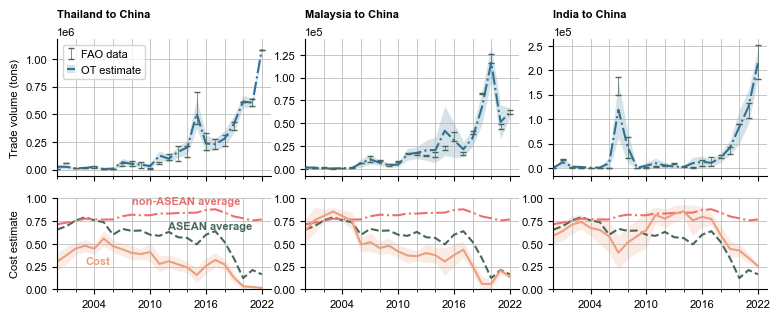

In [16]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7.1, 2.5), sharex=True, gridspec_kw={'height_ratios': [1.5, 1]})

# Plot the ASEAN and non-ASEAN means
ASEAN_mean = dsets["Sugar"]["Predictions"]["mean"].sel({"Source": ["THA", "IDN", "MYS", "LAO", "VNM", "PHL"]}).mean("Source").sel({"variable": "C", "Destination": "CHN"})
non_ASEAN_mean = dsets["Sugar"]["Predictions"]["mean"].sel({"Source": [c for c in dsets["Sugar"]["Predictions"].coords["Source"].data if c not in ["THA", "IDN", "MYS", "LAO", "VNM", "PHL"]]}).mean("Source").sel({"variable": "C", "Destination": "CHN"})
for idx in [0, 1, 2]:
    _mA = axs[1, idx].plot(ASEAN_mean.coords["Year"], ASEAN_mean, label="ASEAN mean", 
                        linestyle='dashed', color=colors['c_darkgreen'])
    _mnA = axs[1, idx].plot(ASEAN_mean.coords["Year"], non_ASEAN_mean, label="non-ASEAN mean", 
                        linestyle='-.', color=colors['c_red'])

importer = "CHN"

# Collect the handles for the legend
handles = []

for idx, exporter in enumerate(["THA", "MYS", "IND"]):

    ax = axs[0, idx]
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    # Plot the true quantity flow (FAO data)
    _T = dsets["Sugar"]["FAO_data"].sel({"Source": exporter, "Destination": importer}).dropna("Year")
    _d = ax.errorbar(_T.coords["Year"], _T.mean("Reporter"), yerr=_T.std("Reporter"), color=colors['c_darkgreen'], lw=0, elinewidth=0.5, capsize=2, label=f"FAO data", zorder=5)

    # Plot the predicted transport flow
    _T_pred = dsets["Sugar"]["Predictions"].sel({"variable": "T_pred", "Source": exporter, "Destination": importer})
    _fb = ax.fill_between(
        _T_pred.coords["Year"], 
        _T_pred["mean"] - _T_pred["std"], 
        _T_pred["mean"] + _T_pred["std"], 
        alpha=0.2, lw=0, color=colors['c_darkblue']
    )
    _l = ax.plot(_T_pred.coords["Year"], _T_pred["mean"], color=colors['c_darkblue'], linestyle='-.')
    if idx == 0:
        handles += [_d, (_fb, _l[0])]  
        
    # Set the title
    ax.set_title(f"{property_from_iso3(lookup_table, exporter, item='Name')} to {property_from_iso3(lookup_table, importer, item='Name')}", y=1.1, x=0, **axes_title_props)

    # Plot the predicted cost
    ax = axs[1, idx]
    _C_pred = dsets["Sugar"]["Predictions"].sel({"variable": "C", "Source": exporter, "Destination": importer})
    _fb = ax.fill_between(_C_pred.coords["Year"], 
                    _C_pred["mean"]-_C_pred["std"], # Remove lower bound on log-scale
                    _C_pred["mean"]+_C_pred["std"], alpha=0.2, color=colors['c_orange'], lw=0)
    _l = ax.plot(_C_pred.coords["Year"], _C_pred["mean"], label="Cost", color=colors['c_orange'])
    ax.set_ylim(0, 1)

for ax in axs.flatten():
    ax.set_xlim(2000, 2023)
    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.grid(True, axis='x', which='both')

# Add a legend and labels
axs[0, 0].legend(handles=handles, labels=["FAO data", "OT estimate"], handlelength=0.7, handletextpad=0.5)
axs[0, 0].set_ylabel("Trade volume (tons)")
axs[1, 0].set_ylabel("Cost estimate")

# Add annotations
axs[1, 0].annotate('Cost', (2003, 0.28), ha='left', color=colors['c_orange'], fontweight='bold')
axs[1, 0].annotate('ASEAN average', (2021, 0.66), ha='right', color=colors['c_darkgreen'], fontweight='bold')
axs[1, 0].annotate('non-ASEAN average', (2008, 0.94), color=colors['c_red'], fontweight='bold')

fig.subplots_adjust(hspace=0.2, wspace=0.16)

### Soya beans

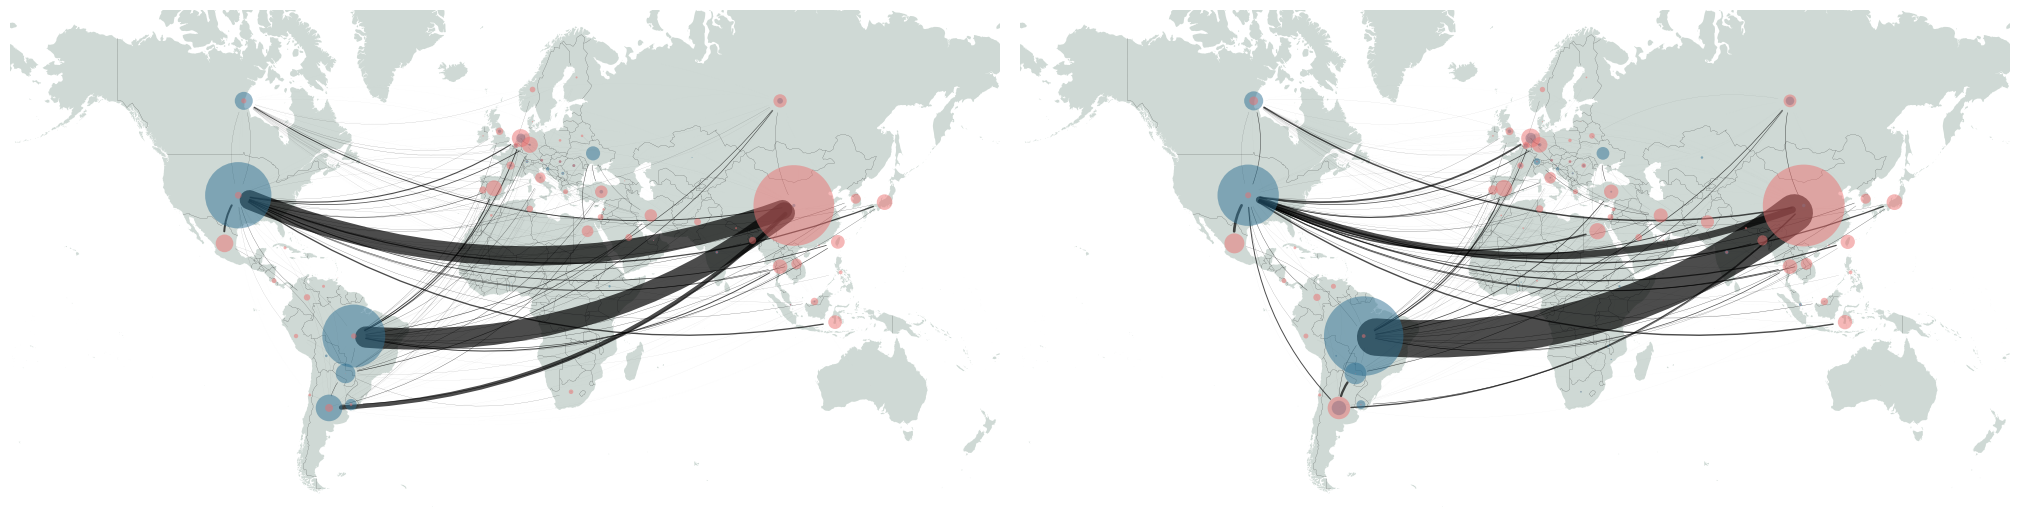

In [17]:
# Compare the global soya bean trade, 2016--2018
fig, axs = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Mercator()), ncols=2)
_plot_props = dict(fig=fig, arrow_dict=dict(arrowstyle='-'), size_factor=0.02, width_factor=8e-3, add_sea=False, landcolor=colors['c_lightgrey'], exporter_color=colors['c_darkblue'], importer_color=colors['c_red'])

plot_world_network(dsets["Soya"]["FAO_data"].sel({"Year": 2016}).mean("Reporter", skipna=True), lookup_table, ax=axs[0], **_plot_props)

plot_world_network(dsets["Soya"]["FAO_data"].sel({"Year": 2018}).mean("Reporter", skipna=True), lookup_table, ax=axs[1], **_plot_props)
fig.subplots_adjust(wspace=0.02, hspace=0)

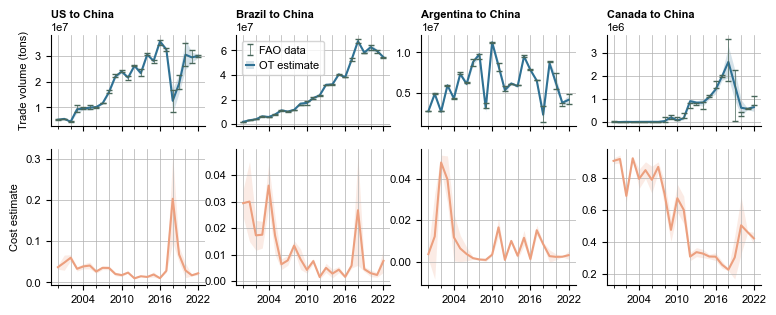

In [18]:
# Comparison of exports to China
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(7.1, 2.5), sharex=True, gridspec_kw={'height_ratios': [1, 1.5]})

im = "CHN"

handles = []
for idx, ex in enumerate(["USA", "BRA", "ARG", "CAN"]):
    
    ax = axs[0, idx]
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    # True transport flow (quantity)
    _T = dsets["Soya"]["FAO_data"].sel({"Source": ex, "Destination": im}).dropna("Year")

    # Plot the true quantity flow
    _d = ax.errorbar(_T.coords["Year"], _T.mean("Reporter"), yerr=_T.std("Reporter"), color=colors['c_darkgreen'], lw=0, elinewidth=0.5, capsize=2, label=f"FAO data", zorder=5)

    # Plot the predicted transport flow
    _T_pred = dsets["Soya"]["Predictions"].sel({"variable": "T_pred", "Source": ex, "Destination": im})
    _fb = ax.fill_between(
        _T_pred.coords["Year"], 
        _T_pred["mean"] - _T_pred["std"], 
        _T_pred["mean"] + _T_pred["std"], 
        alpha=0.2, lw=0, color=colors['c_darkblue']
    )
    _l = ax.plot(_T_pred.coords["Year"], _T_pred["mean"], color=colors['c_darkblue'], linestyle='-')
    
    ax.set_title(f"{property_from_iso3(lookup_table, ex, item='Name')} to {property_from_iso3(lookup_table, im, item='Name')}", y=1.1, x=0.0, ha='left', fontweight='bold')
    if idx == 0:
        handles += [_d, (_fb, _l[0])]
    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.grid(True, axis='x', which='both')
    ax = axs[1, idx]
    _C_pred = dsets["Soya"]["Predictions"].sel({"variable": "C", "Source": ex, "Destination": im})
    _fb = ax.fill_between(_C_pred.coords["Year"], 
                    _C_pred["mean"]-_C_pred["std"], # Remove lower bound on log-scale
                    _C_pred["mean"]+_C_pred["std"], alpha=0.2, color=colors['c_orange'], lw=0)
    _l = ax.plot(_C_pred.coords["Year"], _C_pred["mean"], label="Cost", color=colors['c_orange'])

    ax.xaxis.set_major_locator(MultipleLocator(6))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.grid(True, axis='x', which='both')

axs[0, 1].legend(handles=handles, labels=["FAO data", "OT estimate"], handlelength=0.7, handletextpad=0.5)
 
axs[0, 0].set_ylabel("Trade volume (tons)")
axs[1, 0].set_ylabel("Cost estimate")

fig.subplots_adjust(hspace=0.2, wspace=0.2)

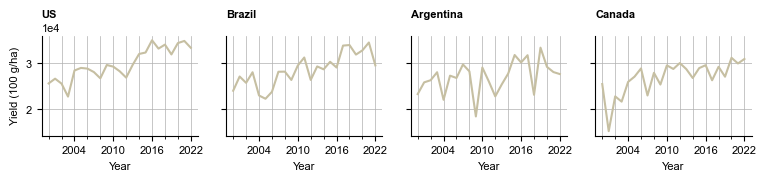

In [19]:
# Plot the yields for different countries
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(7.1, 1), sharex=True, sharey=True)

for idx, country in enumerate(["USA", "BRA", "ARG", "CAN"]):
    axs[idx].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    yields.sel({"Item": "Soya beans; 100 g/ha", "Area": country, "Year": range(2000, 2023)}).plot(ax=axs[idx], color=colors['c_lightbrown'])
    axs[idx].set_ylabel('')
    axs[idx].set_title(f"{property_from_iso3(lookup_table, country, item='Name')}", fontweight='bold', ha='left', x=0.0, y=1.1)
    axs[idx].xaxis.set_major_locator(MultipleLocator(6))
    axs[idx].xaxis.set_minor_locator(MultipleLocator(2))
    axs[idx].grid(True, axis='x', which='both')
axs[0].set_ylabel("Yield (100 g/ha)")

fig.subplots_adjust(hspace=0.2, wspace=0.18, top=1, bottom=0, left=0, right=1)

---
# Brexit
---

### Vegetables

In [20]:
def _get_predictions(comm):
    return dsets[comm]["Predictions"]

Vegetable_diff = _get_predictions("Lettuce")["mean"].sel({"Year": [2016, 2022], "variable": "C"}, drop=True).diff("Year").sel({"Destination": ["GBR", "IRL"]})
Vegetable_trade_diff = (_get_predictions("Lettuce")["mean"].sel({"Year": [2016, 2022], "variable": "T_pred"}).diff("Year") / _get_predictions("Lettuce")["mean"].sel({"Year": 2016, "variable": "T_pred"}).squeeze().data).sel({"Destination": ["GBR", "IRL"]})

Tomato_diff = _get_predictions("Tomatoes")["mean"].sel({"Year": [2016, 2022], "variable": "C"}, drop=True).diff("Year").sel({"Destination": ["GBR", "IRL"]})
Tomato_trade_diff = (_get_predictions("Tomatoes")["mean"].sel({"Year": [2016, 2022], "variable": "T_pred"}).diff("Year") / _get_predictions("Tomatoes")["mean"].sel({"Year": 2016, "variable": "T_pred"}).squeeze().data).sel({"Destination": ["GBR", "IRL"]})

Cucumber_diff = _get_predictions("Cucumbers")["mean"].sel({"Year": [2016, 2022], "variable": "C"}, drop=True).diff("Year").sel({"Destination": ["GBR", "IRL"]})
Cucumber_trade_diff = (_get_predictions("Cucumbers")["mean"].sel({"Year": [2016, 2022], "variable": "T_pred"}).diff("Year") / _get_predictions("Cucumbers")["mean"].sel({"Year": 2016, "variable": "T_pred"}).squeeze().data).sel({"Destination": ["GBR", "IRL"]})

[None, None]

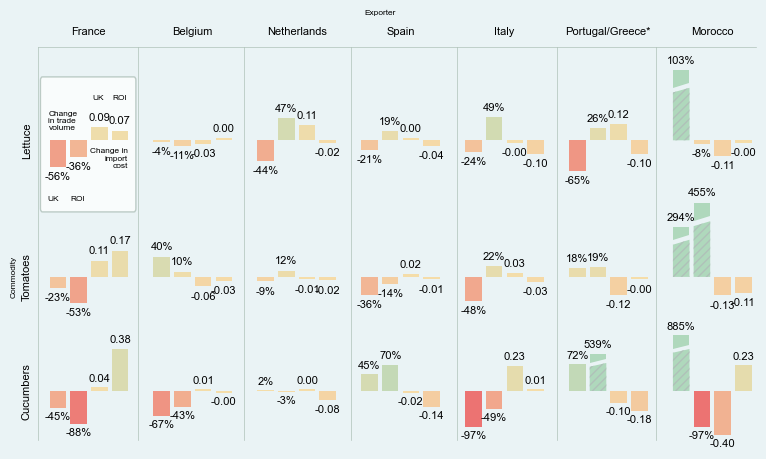

In [21]:
# Comparison panel of vegetable trade
cm = ColorManager(
    cmap={'continuous': True, 'from_values': {0: colors['c_red'], 0.5: colors['c_yellow'], 1: colors['c_lightgreen'], }},
    vmin=-1,
    vmax=+1
)

fig, axs = plt.subplots(ncols=7, nrows=3, figsize=(7.1, 3.75), sharey='row')
for row, (_comm, _country_list) in enumerate([
                            ("Vegetable", ["FRA", "BEL", "NLD", "ESP", "ITA", "PRT", "MAR"]), 
                            ("Tomatoes", ["FRA", "BEL", "NLD", "ESP", "ITA", "PRT", "MAR"]), 
                            ("Cucumbers", ["FRA", "BEL", "NLD", "ESP", "ITA", "GRC", "MAR"])
]):
    
    _trade_diff = Vegetable_trade_diff if _comm == "Vegetable" else Tomato_trade_diff if _comm == "Tomatoes" else Cucumber_trade_diff
    _diff = Vegetable_diff if _comm == "Vegetable" else Tomato_diff if _comm == "Tomatoes" else Cucumber_diff
    _trade_diff = _trade_diff.sel({"Source": _country_list})
    _diff = _diff.sel({"Source": _country_list})
    
    for col, country in enumerate(_country_list):

        _T = _trade_diff.sel({"Source": country, "Destination": "GBR"}).data[0]
        if _T <= 1.0:
            _rect = axs[row, col].bar([0], [_T], color=cm.map_to_color(_T), lw=0)
            _patch = _rect.get_children()[0]
            _x, _y = 0, _patch._height
        else:
            _h = max(1., 1.5*_T / _trade_diff.data.max())
            _rect_1 = patches.Polygon([(-0.4, 0), (-0.4, 0.75*_h-0.1), (0.4, 0.75*_h), (0.4, 0)], color=cm.map_to_color(_T), lw=0, ec=colors['c_lightgrey'], hatch='////')
            _rect = patches.Polygon([(-0.4, 0.75*_h), (-0.4, _h), (0.4, _h), (0.4, 0.75*_h+0.1)], color=cm.map_to_color(_T), lw=0)
            axs[row, col].add_patch(_rect_1)
            axs[row, col].add_patch(_rect)
            _x, _y = 0, _h
        
        axs[row, col].text(_x, _y + np.sign(_y)*0.1, "{t:.0f}%".format(t=100*_T), ha='center', va='top' if _y < 0 else 'bottom')
        
        _T = _trade_diff.sel({"Source": country, "Destination": "IRL"}).data[0]
        if _T <= 1.0:
            _rect = axs[row, col].bar([1], [_T], color=cm.map_to_color(_T), lw=0)
            _patch = _rect.get_children()[0]
            _x, _y = 1, _patch._height
        else:
            _h = max(1., 1.5*_T / _trade_diff.data.max())
            _rect_1 = patches.Polygon([(0.6, 0), (0.6, 0.75*_h-0.1), (1.4, 0.75*_h), (1.4, 0)], color=cm.map_to_color(_T), lw=0, ec=colors['c_lightgrey'], hatch='////')
            _rect = patches.Polygon([(0.6, 0.75*_h), (0.6, _h), (1.4, _h), (1.4, 0.75*_h+0.1)], color=cm.map_to_color(_T), lw=0)
            axs[row, col].add_patch(_rect_1)
            axs[row, col].add_patch(_rect)
            _x, _y = 1, _h
        axs[row, col].text(_x, _y + np.sign(_y)*0.1, "{t:.0f}%".format(t=100*_T), ha='center', va='top' if _T < 0 else 'bottom')
            
        _C = _diff.sel({"Destination": "GBR", "Source": country}).squeeze().data
        _rect = axs[row, col].bar([2], [np.sign(_C)*max(3*abs(_C), 0.05)], color=cm.map_to_color(_C) if _C > 0 else cm.map_to_color(_C), lw=0)
        _patch = _rect.get_children()[0]
        _x, _y = 2, _patch._height
        axs[row, col].text(_x, _y + np.sign(_y)*0.1, "{t:.2f}".format(t=_C), ha='center', va='bottom' if _C > 0 else 'top')
    
        _C = _diff.sel({"Destination": "IRL", "Source": country}).squeeze().data
        _rect = axs[row, col].bar([3], [np.sign(_C)*max(3*abs(_C), 0.05)], color=cm.map_to_color(_C) if _C > 0 else cm.map_to_color(_C), lw=0)
        _patch = _rect.get_children()[0]
        _x, _y = 3, _patch._height
        
        axs[row, col].text(_x, _y + np.sign(_y)*0.1, "{t:.2f}".format(t=_C), ha='center', va='bottom' if _C > 0 else 'top')
        
        if row == 0:
            axs[row, col].set_title(property_from_iso3(lookup_table, country, item='Name', correct=True), y=1.2)
        axs[row, col].axis('off')

axs[0, 0].text(-1.5, 0., 'Lettuce', rotation=90, ha='center', va='center')
axs[1, 0].text(-1.5, 0., 'Tomatoes', rotation=90, ha='center', va='center')
axs[2, 0].text(-1.5, 0., 'Cucumbers', rotation=90, ha='center', va='center')
axs[0, 3].text(0.5, 2.8, 'Exporter', ha='center', va='top', fontsize=6)
axs[1, 0].text(-2, 0, 'Commodity', ha='right', va='center', fontsize=6, rotation=90)
axs[0, 5].set_title("Portugal/Greece*", y=1.2)

box_ax = fig.add_axes([-0.01, 0.6, 0.14, 0.45], zorder=-2)
box_ax.xaxis.set_visible(False)
box_ax.yaxis.set_visible(False)
for s in ['top', 'bottom', 'right', 'left']:
    box_ax.spines[s].set_visible(False)


rect = patches.FancyBboxPatch((0.02, 0.02), 0.96, 0.8, linewidth=1, edgecolor=colors['c_lightgrey'], alpha=0.8, facecolor='white', transform=box_ax.transAxes, boxstyle='Round, pad=0, rounding_size=0.02')

# Add the patch to the Axes
box_ax.add_patch(rect)
box_ax.patch.set(fill=None)
box_ax.text(0.15, 0.1, 'UK', ha='center', va='center', fontsize=6)
box_ax.text(0.40, 0.1, 'ROI', ha='center', va='center', fontsize=6)
box_ax.text(0.60, 0.7, 'UK', ha='center', va='center', fontsize=6)
box_ax.text(0.82, 0.7, 'ROI', ha='center', va='center', fontsize=6)
box_ax.text(0.1, 0.5, 'Change\nin trade\nvolume', ha='left', va='bottom', fontsize=6)
box_ax.text(0.90, 0.4, 'Change in\nimport\ncost', ha='right', va='top', fontsize=6)

import matplotlib.lines as lines

for _line_x in [-0.01, 0.13, 0.28, 0.43, 0.58, 0.72, 0.86]:
    fig.add_artist(lines.Line2D([_line_x, _line_x], [0, 1.05], c=colors['c_lightgrey'], lw=0.5))
fig.add_artist(lines.Line2D([-0.01, 1.], [1.05, 1.05], c=colors['c_lightgrey'], lw=0.5))

fig.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0.2)
fig.patch.set(fc=colors['c_lightblue'], alpha=0.2)
# fig.savefig("/Users/thomasgaskin/Documents/Projects/IOT/Figures/Brexit_comp_all.pdf", bbox_inches='tight') 

[None, None]

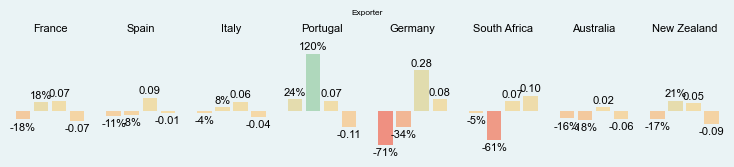

In [22]:
# Comparison panel of wine trade
Wine_diff = dsets["Wine"]["Predictions"]["mean"].sel({"Year": [2016, 2022], "variable": "C"}, drop=True).diff("Year").sel({"Destination": ["GBR", "IRL"]})
Wine_trade_diff = (dsets["Wine"]["Predictions"]["mean"].sel({"Year": [2016, 2022], "variable": "T_pred"}).diff("Year") / dsets["Wine"]["Predictions"]["mean"].sel({"Year": 2016, "variable": "T_pred"}).squeeze().data).sel({"Destination": ["GBR", "IRL"]})

cm = ColorManager(
    cmap={'continuous': True, 'from_values': {0: colors['c_red'], 0.5: colors['c_yellow'], 1: colors['c_lightgreen'], }},
    vmin=-1,
    vmax=+1
)

fig, axs = plt.subplots(ncols=8, figsize=(7.1, 1), sharey=True)
for idx, country in enumerate(["FRA", "ESP", "ITA", "PRT", "DEU", "ZAF", "AUS", "NZL"]):
   
    _T = Wine_trade_diff.sel({"Source": country, "Destination": "GBR"}).data[0]
    if _T < 0.6:
        _rect = axs[idx].bar([0], [_T], color=cm.map_to_color(_T), lw=0)
        _patch = _rect.get_children()[0]
        _x, _y = 0, _patch._height
    else:
        _rect_1 = patches.Polygon([(-0.4, 0), (-0.4, 0.7), (0.4, 0.8), (0.4, 0)], color=cm.map_to_color(_T), lw=0)
        _rect = patches.Polygon([(-0.4, 0.75), (-0.4, 1.5), (0.4, 1.5), (0.4, 0.85)], color=cm.map_to_color(_T), lw=0)
        axs[idx].add_patch(_rect_1)
        axs[idx].add_patch(_rect)
        _x, _y = 0, 1.5

    axs[idx].text(_x, _y + np.sign(_y)*0.05, "{t:.0f}%".format(t=100*_T), ha='center', va='top' if _y < 0 else 'bottom')
    
    _T = Wine_trade_diff.sel({"Source": country, "Destination": "IRL"}).data[0]
    _rect = axs[idx].bar([1], [_T], color=cm.map_to_color(_T), lw=0)
    _patch = _rect.get_children()[0]
    _x, _y = 1, _patch._height
    axs[idx].text(_x, _y + np.sign(_y)*0.05, "{t:.0f}%".format(t=100*_T), ha='center', va='top' if _T < 0 else 'bottom')
            
    _C = Wine_diff.sel({"Destination": "GBR", "Source": country}).squeeze().data
    _rect = axs[idx].bar([2], [np.sign(_C)*max(3*abs(_C), 0.05)], color=cm.map_to_color(_C) if _C > 0 else cm.map_to_color(_C), lw=0)
    _patch = _rect.get_children()[0]
    _x, _y = 2, _patch._height
    axs[idx].text(_x, _y + np.sign(_y)*0.05, "{t:.2f}".format(t=_C), ha='center', va='bottom' if _C > 0 else 'top')

    _C = Wine_diff.sel({"Destination": "IRL", "Source": country}).squeeze().data
    _rect = axs[idx].bar([3], [np.sign(_C)*max(3*abs(_C), 0.05)], color=cm.map_to_color(_C) if _C > 0 else cm.map_to_color(_C), lw=0)
    _patch = _rect.get_children()[0]
    _x, _y = 3, _patch._height
    
    axs[idx].text(_x, _y + np.sign(_y)*0.05, "{t:.2f}".format(t=_C), ha='center', va='bottom' if _C > 0 else 'top')
    axs[idx].set_title(property_from_iso3(lookup_table, country, item='Name', correct=True), y=1.1)

    axs[idx].axis('off')
fig.suptitle('Exporter', y=1.4, fontsize=6)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig.patch.set(fc=colors['c_lightblue'], alpha=0.2)

---
# General patterns
---

### Average trade volume as a function of cost, color-coded by gdp/capita and total population

In [23]:
UN_data = xr.load_dataset("data/UN_data.nc")
pop = UN_data['Total Population, as of 1 January (thousands)'].transpose('Year', ...).sel({'Year': range(2000, 2022)})
pop = xr.concat([pop, np.nan*pop.sel({"Country ISO": ["USA", "DEU"]}).assign_coords({"Country ISO": ['Other', 'Serbia and Montenegro']})], dim='Country ISO')
pop = xr.concat([pop, np.nan*pop.sel({"Year": [2021]}).assign_coords({"Year": [2022]})], dim='Year')

gdp = pd.read_csv("data/WorldBank_GDP_data.csv")
gdp = gdp.drop(["Indicator Name", "Country Name", "Indicator Code"], axis=1)
gdp = gdp.set_index("Country Code")
gdp.loc['TWN', :] = np.nan
gdp.loc['Serbia and Montenegro', :] = np.nan
gdp.loc['Other', :] = np.nan
gdp["Year"] = 0
test = []
for c in gdp.columns[:-1]:
    _g = gdp[[c, "Year"]].copy()
    _g.rename({c: "GDP per capita"}, axis=1, inplace=True)
    _g.loc[:, "Year"] = int(c)
    test.append(_g)
    del _g
gdp = pd.concat(test, axis=0).reset_index().set_index(["Country Code", "Year"]).to_xarray()["GDP per capita"].transpose('Year', ...).sel({'Year': range(2000, 2023)}).rename({"Country Code": "Country ISO"})
del test

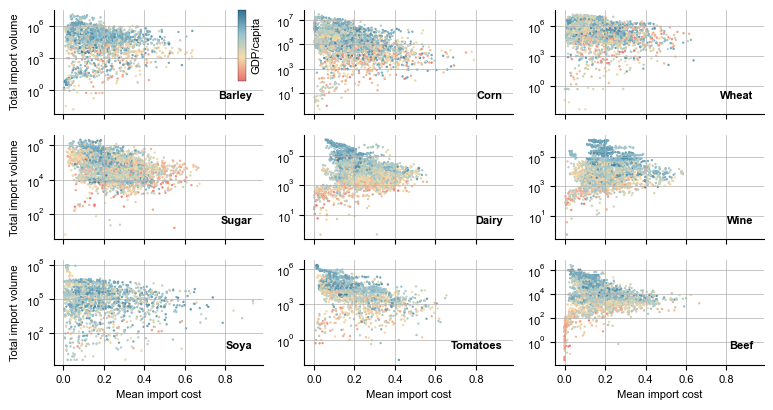

In [24]:
# Mean import cost and mean import volume, all years
hue=gdp
cm = ColorManager(
    cmap={'from_values': {0: colors['c_red'], 0.333: colors['c_yellow'], 0.66: colors['c_lightblue'], 1: colors['c_darkblue']}, 'continuous': True}, vmin=hue.min(), vmax=hue.max(), norm='LogNorm'
)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(7.1, 3.55), sharex=True)
for idx, commodity in enumerate(["Barley", "Corn", "Wheat", "Sugar", "Dairy", "Wine", "Soya", "Tomatoes", "Beef"]):
    
    pred = dsets[commodity]["Predictions"]["mean"]
    _hue = hue.sel({"Country ISO": pred.coords["Destination"]})
    for y in pred.coords["Year"].data:
        
        T_mean = pred.sel({"variable": "T_pred", "Year": y}).sum("Source")
        C_mean = (pred.sel({"variable": "T_pred", 'Year': y}) * pred.sel({"variable": "C", 'Year': y})).sum("Source") / T_mean

        im = axs.flatten()[idx].scatter(C_mean, T_mean, c=_hue.sel({"Year": y}).data, cmap=cm.cmap, norm=cm.norm, alpha=1, s=0.5)
    axs.flatten()[idx].set_yscale('log')
    axs.flatten()[idx].set_title(commodity, x=0.95, y=0.05, fontweight='bold', ha='right', va='bottom')
for i in range(3):
    axs[-1, i].set_xlabel("Mean import cost")
    axs[i, 0].set_ylabel("Total import volume")
_cax = fig.add_axes([0.26, 0.8, 0.01, 0.2])
_cbar = colorbar.Colorbar(_cax, cmap=cm.cmap, orientation='vertical', location='right', drawedges=False, ticks=[], label='GDP/capita')
_cbar.outline.set_linewidth(0.2)

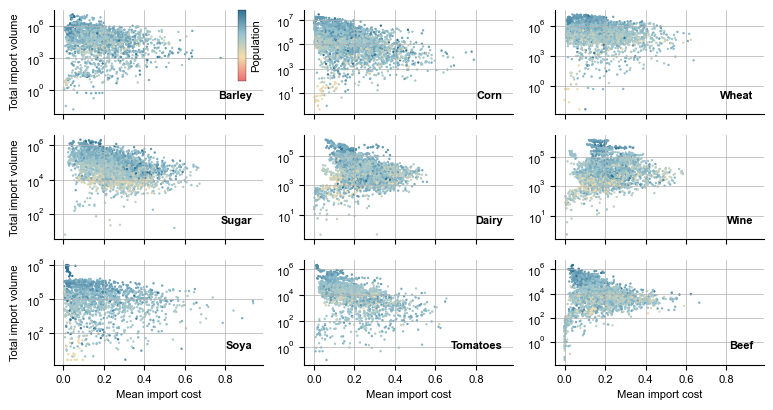

In [25]:
# Mean import cost and mean import volume, all years, color-coded by population
hue=pop
cm = ColorManager(
    cmap={'from_values': {0: colors['c_red'], 0.333: colors['c_yellow'], 0.66: colors['c_lightblue'], 1: colors['c_darkblue']}, 'continuous': True}, vmin=hue.min(), vmax=hue.max(), norm='LogNorm'
)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(7.1, 3.55), sharex=True)
for idx, commodity in enumerate(["Barley", "Corn", "Wheat", "Sugar", "Dairy", "Wine", "Soya", "Tomatoes", "Beef"]):
    
    pred = dsets[commodity]["Predictions"]["mean"]
    _hue = hue.sel({"Country ISO": pred.coords["Destination"]})
    for y in pred.coords["Year"].data:
        
        T_mean = pred.sel({"variable": "T_pred", "Year": y}).sum("Source")
        C_mean = (pred.sel({"variable": "T_pred", 'Year': y}) * pred.sel({"variable": "C", 'Year': y})).sum("Source") / T_mean

        im = axs.flatten()[idx].scatter(C_mean, T_mean, c=_hue.sel({"Year": y}).data, cmap=cm.cmap, norm=cm.norm, alpha=1, s=0.5)
    axs.flatten()[idx].set_yscale('log')
    axs.flatten()[idx].set_title(commodity, x=0.95, y=0.05, fontweight='bold', ha='right', va='bottom')
for i in range(3):
    axs[-1, i].set_xlabel("Mean import cost")
    axs[i, 0].set_ylabel("Total import volume")
_cax = fig.add_axes([0.26, 0.8, 0.01, 0.2])
_cbar = colorbar.Colorbar(_cax, cmap=cm.cmap, orientation='vertical', location='right', drawedges=False, ticks=[], label='Population')
_cbar.outline.set_linewidth(0.2)